In [1]:
!pip -q install sklearn matplotlib pandas

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K

from sklearn.metrics import classification_report

import os
import warnings
import math

In [3]:
#parameters
batch_size = 64
train_dir = "images/training"
test_dir = "images/testing"
rand_seed=42

In [4]:
#loading InceptionV3 with pre-trained weights and without classifiers
pre_trained_model = InceptionV3(input_shape = (150,270,3), weights='imagenet', include_top=False)

2022-02-11 08:36:10.477001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 08:36:10.489505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 08:36:10.490404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 08:36:10.492737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 08:36:10.493633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

87924736/87910968 [==============================] - 4s 0us/step


In [5]:
#set layers to be non-trainable for pre-trained model (freeze)
for layer in pre_trained_model.layers:
    layer.trainable = False

In [6]:
#image augmentation applied to training images
train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               shear_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest').flow_from_directory(train_dir, 
                                                                        class_mode='binary',
                                                                        target_size=(270, 150), 
                                                                        batch_size=batch_size,
                                                                        seed=rand_seed, 
                                                                        shuffle=True)

#no image augmentation applied to test images
test_gen = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_dir, 
                                                                    class_mode='binary',
                                                                    target_size=(270, 150), 
                                                                    batch_size=batch_size,
                                                                    seed=rand_seed, 
                                                                    shuffle=True)

Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


Showing 10 images from the first batch


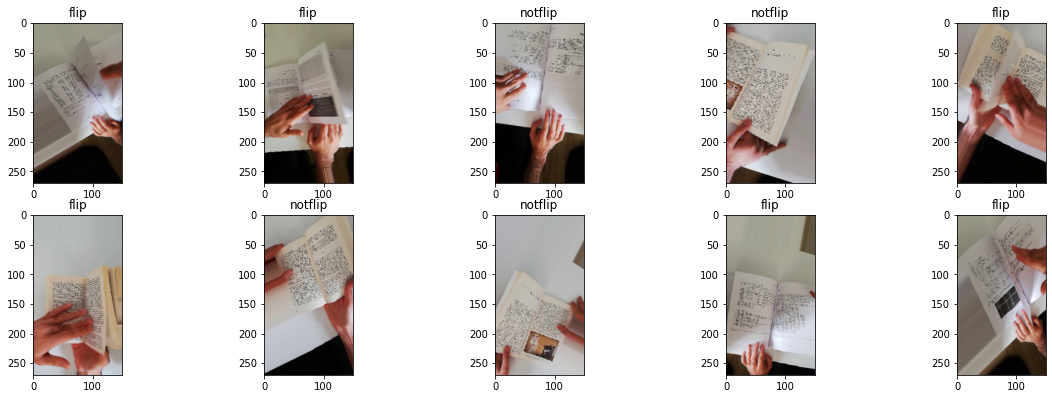

In [7]:
#viewing the training data
new_dict = {}
for key, value in train_gen.class_indices.items():
  new_dict[value] = key

def label_plot(x):
      return new_dict[x]

batch = next(train_gen)  # returns the next batch of images and labels as tupe where 0 index is images and 1 is label

plt.figure(figsize=(20,10))
columns = 5

new_dict = {}
for key, value in train_gen.class_indices.items():
  new_dict[value] = key

#plotting the first 10 images from one of the batch
print("Showing 10 images from the first batch")
for idx in range(10):
  plt.subplot(int(len(range(10))/columns + 1), columns, idx + 1)
  plt.title(label_plot(batch[1][idx]))
  plt.imshow(batch[0][idx])

In [8]:
#using the pre_trained_model as feature extractor in our model
#flatten the output layer from pre trained model to 1 dimension
model = layers.Flatten()(pre_trained_model.output)
#add a fully connected layer
model = layers.Dense(1024, activation='relu')(model)
#add a final sigmoid layer for classification
model = layers.Dense(1, activation='sigmoid')(model)

model = tf.keras.Model(pre_trained_model.input, model)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ['accuracy'])

In [9]:
history = model.fit(train_gen, validation_data = test_gen, steps_per_epoch = len(train_gen), validation_steps = len(test_gen), epochs=10, verbose=1)

2022-02-11 08:36:23.226002: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-02-11 08:36:28.657464: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


38/38 [==============================] - 111s 3s/step - loss: 16.8004 - accuracy: 0.6083 - val_loss: 2.6377 - val_accuracy: 0.7370
Epoch 2/10
38/38 [==============================] - 60s 2s/step - loss: 1.1780 - accuracy: 0.7734 - val_loss: 0.4613 - val_accuracy: 0.8626
Epoch 3/10
38/38 [==============================] - 57s 2s/step - loss: 0.6322 - accuracy: 0.8211 - val_loss: 0.4216 - val_accuracy: 0.8559
Epoch 4/10
38/38 [==============================] - 59s 2s/step - loss: 0.8353 - accuracy: 0.7893 - val_loss: 0.4135 - val_accuracy: 0.8760
Epoch 5/10
38/38 [==============================] - 57s 1s/step - loss: 0.5941 - accuracy: 0.8370 - val_loss: 0.7172 - val_accuracy: 0.8308
Epoch 6/10
38/38 [==============================] - 59s 2s/step - loss: 0.6395 - accuracy: 0.8081 - val_loss: 0.7578 - val_accuracy: 0.8358
Epoch 7/10
38/38 [==============================] - 58s 2s/step - loss: 0.7403 - accuracy: 0.8048 - val_loss: 0.3157 - val_accuracy: 0.9146
Epoch 8/10
38/38 [===========

In [10]:
#evaluating the model

#turning off the shuffle in test data
test_gen = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_dir, 
                                                                    class_mode='binary',
                                                                    target_size=(270, 150), 
                                                                    batch_size=batch_size,
                                                                    seed=rand_seed, 
                                                                    shuffle=False)

#prediction
preds = model.predict(test_gen, steps = len(test_gen))

#converting prediciton to 0 and 1 using threshold of 0.5
for idx, pred in enumerate(preds):
  if pred < 0.5:
    preds[idx] = 0
  else:
    preds[idx] = 1

target_names = list(test_gen.class_indices.keys())   
print(classification_report(test_gen.classes, preds, target_names=target_names))

Found 597 images belonging to 2 classes.
              precision    recall  f1-score   support

        flip       0.77      0.97      0.86       290
     notflip       0.97      0.73      0.83       307

    accuracy                           0.85       597
   macro avg       0.87      0.85      0.85       597
weighted avg       0.87      0.85      0.85       597



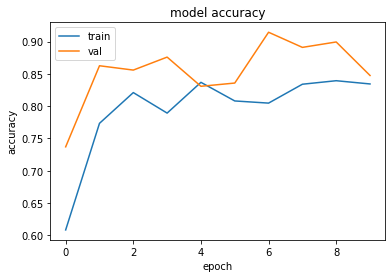

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

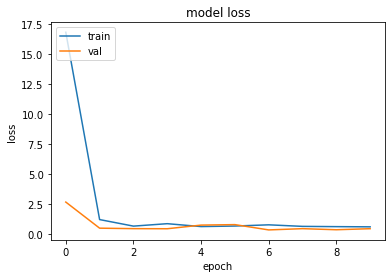

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Overall achieved an F1 score of 85% as our baseline model. Its not a bad start and if I had used earlystopping or callback, the model would have been closer to 90% F1 Score. In anycase, moving onto the next-step - using learning rate optimizer and fine tuning